<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_9/Aula_9_Inpairs_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'
print(f'Meu nome é {nome}')

Meu nome é Leonardo Augusto da Silva Pacheco


# Enunciado

https://github.com/leonardo3108/IA368dd/blob/main/exercicios/Aula_9/enunciado.md

# Setup

## Hiperparâmetros

In [1]:
model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
max_seq_length = 512
batch_size = 16
lr = 5e-5
epochs=20
model_save_dir = 'model_save'

## Preparação das pastas

In [2]:
!mkdir $model_save_dir

## Instalação de libs

In [3]:
!pip install huggingface_hub 
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

## Importação de libs

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import datasets
import json
import os
import torch

from huggingface_hub import login
from pathlib import Path
from statistics import mean
from torch.utils import data
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AdamW, AutoModelForSequenceClassification, AutoTokenizer, BatchEncoding, get_linear_schedule_with_warmup

## Login na Hugging Face

In [5]:
login()

## Utilização de GPUs

In [6]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [7]:
if dev != 'cpu':
    !nvidia-smi

Thu May  4 01:13:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção - TREC-COVID

In [8]:
!wget -nc 'https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip'

--2023-05-04 01:13:38--  https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/trec-covid.zip
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73876720 (70M) [application/zip]
Saving to: ‘trec-covid.zip’

trec-covid.zip      100%[===================>]  70.45M   229MB/s    in 0.3s    

2023-05-04 01:13:39 (229 MB/s) - ‘trec-covid.zip’ saved [73876720/73876720]



In [9]:
!unzip -o trec-covid.zip

Archive:  trec-covid.zip
   creating: trec-covid/
   creating: trec-covid/qrels/
  inflating: trec-covid/qrels/test.tsv  
  inflating: trec-covid/corpus.jsonl  
  inflating: trec-covid/queries.jsonl  


## Tratamento - corpus

In [10]:
corpus = {}
with open('trec-covid/corpus.jsonl') as fin:
    for i, line in enumerate(fin):
        doc = json.loads(line)
        corpus[doc['_id']] = f"{doc['title']} {doc['text']}"

for id in list(corpus.keys())[:10]:
    print(id + ':', corpus[id])

ug7v899j: Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumon

## Obtenção - exemplos

In [11]:
dataset_experiment = datasets.load_dataset('unicamp-dl/trec-covid-experiment')
dataset_experiment

Generating example split: 0 examples [00:00, ? examples/s]

Generating example2 split: 0 examples [00:00, ? examples/s]

Generating eduseiti_100_queries_expansion_20230501_01 split: 0 examples [00:00, ? examples/s]

Generating leandro_carisio_01 split: 0 examples [00:00, ? examples/s]

Generating thales_1k_generated_queries_20230429 split: 0 examples [00:00, ? examples/s]

Generating manoel_1k_generated_queries_20230430 split: 0 examples [00:00, ? examples/s]

Generating manoel_2k_generated_queries_20230501 split: 0 examples [00:00, ? examples/s]

Generating thiago_laitz_1k_queries split: 0 examples [00:00, ? examples/s]

Generating mirelle_1k_generated_queries_20230501 split: 0 examples [00:00, ? examples/s]

Generating hugo_padovani_query_generation split: 0 examples [00:00, ? examples/s]

Generating marcus_borela_1k_gptj6b_20230501 split: 0 examples [00:00, ? examples/s]

Generating juliatessler_1000_queries split: 0 examples [00:00, ? examples/s]

Generating pedro_holanda_1k_generated_queries_20230502 split: 0 examples [00:00, ? examples/s]

Generating leonardo_avila_queries_v1 split: 0 examples [00:00, ? examples/s]

Generating marcus_borela_1k_gptj6b_20230501_v2 split: 0 examples [00:00, ? examples/s]

Generating gustavo_1k_cohere split: 0 examples [00:00, ? examples/s]

Generating marcospiau_1k_v1 split: 0 examples [00:00, ? examples/s]

Generating pedrogengo_queries_inparsv1 split: 0 examples [00:00, ? examples/s]

Dataset trec-covid-experiment downloaded and prepared to /root/.cache/huggingface/datasets/unicamp-dl___trec-covid-experiment/default/0.0.0/b4916ab469ccacf895d77d33bd1c846bb5cfdd8b4c50a7d5ee10f01f77e0310a. Subsequent calls will reuse this data.


  0%|          | 0/18 [00:00<?, ?it/s]

DatasetDict({
    example: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    example2: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 3
    })
    eduseiti_100_queries_expansion_20230501_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 463
    })
    leandro_carisio_01: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1001
    })
    thales_1k_generated_queries_20230429: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_1k_generated_queries_20230430: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 1000
    })
    manoel_2k_generated_queries_20230501: Dataset({
        features: ['query', 'positive_doc_id', 'negative_doc_ids'],
        num_rows: 2000
    })
    thiago_l

## Tratamento - exemplos

### Criação do Dataframe

In [28]:
df = pd.concat((v.to_pandas().assign(origin=k) for k,v in dataset_experiment.items()), ignore_index=True)
df

,query,positive_doc_id,negative_doc_ids,origin
0,This is a example query 1,doc1,"[xxx, yyy, zzz]",example
1,This is another example query,doc2,"[aaa, bbb, ccc]",example
2,Example of query with no negative doc_ids,doc2,[],example
3,This is a example query 1 (file 2),doc12222,"[xxx, yyy, zzz]",example2
4,This is another example query (file 2),doc12345,"[aaa, bbb, ccc]",example2
...,...,...,...,...
16673,What are the American Association for Thoracic...,0qh3bwiw,[fhjgdixa],pedrogengo_queries_inparsv1
16674,What is the role of interferon-gamma-inducible...,9aohx31y,[g9nr6pb2],pedrogengo_queries_inparsv1
16675,What is the effect of UV-photofunctionalizatio...,syi763zi,[940h53lj],pedrogengo_queries_inparsv1
16676,What is the virtual foot and ankle physical ex...,lqh7iirz,[ajbypz7g],pedrogengo_queries_inparsv1


### Remoção dos registros de exemplo

In [29]:
df.groupby(['origin']).count()['query']

origin
eduseiti_100_queries_expansion_20230501_01      463
example                                           3
example2                                          3
gustavo_1k_cohere                              1000
hugo_padovani_query_generation                  979
juliatessler_1000_queries                      1000
leandro_carisio_01                             1001
leonardo_avila_queries_v1                       996
manoel_1k_generated_queries_20230430           1000
manoel_2k_generated_queries_20230501           2000
marcospiau_1k_v1                               1000
marcus_borela_1k_gptj6b_20230501               1000
marcus_borela_1k_gptj6b_20230501_v2            1000
mirelle_1k_generated_queries_20230501           999
pedro_holanda_1k_generated_queries_20230502    1088
pedrogengo_queries_inparsv1                    1146
thales_1k_generated_queries_20230429           1000
thiago_laitz_1k_queries                        1000
Name: query, dtype: int64

In [30]:
df = df.query("origin != 'example' and origin != 'example2'")
df

,query,positive_doc_id,negative_doc_ids,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,"[mt00852w, x7ol32mz, b54dymlu, h5vh6px7, bza9a...",eduseiti_100_queries_expansion_20230501_01
7,What strategies can be used to encourage desir...,70hskj1o,"[et84j0qi, xsfolppr, 5t2o287y, kj2tnw8q, j68x0...",eduseiti_100_queries_expansion_20230501_01
8,What are the risks associated with amplifying ...,70hskj1o,"[2c1m04je, rd93y7hu, vlmvi0tf, dbq3z982, 848fs...",eduseiti_100_queries_expansion_20230501_01
9,What research has been conducted on the effect...,70hskj1o,"[49zlztqu, amjqr9hr, hpx4723v, e790rxq9, 95bso...",eduseiti_100_queries_expansion_20230501_01
10,How can collaborations between healthcare work...,70hskj1o,"[eg2lj9zc, prmf9yob, ara8bsws, zjmshwl3, apvc5...",eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
16673,What are the American Association for Thoracic...,0qh3bwiw,[fhjgdixa],pedrogengo_queries_inparsv1
16674,What is the role of interferon-gamma-inducible...,9aohx31y,[g9nr6pb2],pedrogengo_queries_inparsv1
16675,What is the effect of UV-photofunctionalizatio...,syi763zi,[940h53lj],pedrogengo_queries_inparsv1
16676,What is the virtual foot and ankle physical ex...,lqh7iirz,[ajbypz7g],pedrogengo_queries_inparsv1


### Limita a 5 exemplos negativos

In [31]:
df['negative_doc_ids'] = df['negative_doc_ids'].map(lambda vec: vec[0:5])
df

<ipython-input-31-bbab50e2d658>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['negative_doc_ids'] = df['negative_doc_ids'].map(lambda vec: vec[0:5])


,query,positive_doc_id,negative_doc_ids,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,"[mt00852w, x7ol32mz, b54dymlu, h5vh6px7, bza9a...",eduseiti_100_queries_expansion_20230501_01
7,What strategies can be used to encourage desir...,70hskj1o,"[et84j0qi, xsfolppr, 5t2o287y, kj2tnw8q, j68x0...",eduseiti_100_queries_expansion_20230501_01
8,What are the risks associated with amplifying ...,70hskj1o,"[2c1m04je, rd93y7hu, vlmvi0tf, dbq3z982, 848fs...",eduseiti_100_queries_expansion_20230501_01
9,What research has been conducted on the effect...,70hskj1o,"[49zlztqu, amjqr9hr, hpx4723v, e790rxq9, 95bso...",eduseiti_100_queries_expansion_20230501_01
10,How can collaborations between healthcare work...,70hskj1o,"[eg2lj9zc, prmf9yob, ara8bsws, zjmshwl3, apvc5...",eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
16673,What are the American Association for Thoracic...,0qh3bwiw,[fhjgdixa],pedrogengo_queries_inparsv1
16674,What is the role of interferon-gamma-inducible...,9aohx31y,[g9nr6pb2],pedrogengo_queries_inparsv1
16675,What is the effect of UV-photofunctionalizatio...,syi763zi,[940h53lj],pedrogengo_queries_inparsv1
16676,What is the virtual foot and ankle physical ex...,lqh7iirz,[ajbypz7g],pedrogengo_queries_inparsv1


### Muda estrutura - 1 registro por exemplo

- explode expande a lista de exemplos negativos
- melt separa exemplo positivo de negativo
- drop_duplicates remove as duplicatas

In [32]:
df.rename(columns={'positive_doc_id': '1', 'negative_doc_ids': '0'}, inplace=True)

<ipython-input-32-35d02e369c87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'positive_doc_id': '1', 'negative_doc_ids': '0'}, inplace=True)


In [33]:
df = df.explode('0')
df

,query,1,0,origin
6,How can chatbots be designed to effectively sh...,70hskj1o,mt00852w,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,x7ol32mz,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,b54dymlu,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,h5vh6px7,eduseiti_100_queries_expansion_20230501_01
6,How can chatbots be designed to effectively sh...,70hskj1o,bza9agzo,eduseiti_100_queries_expansion_20230501_01
...,...,...,...,...
16673,What are the American Association for Thoracic...,0qh3bwiw,fhjgdixa,pedrogengo_queries_inparsv1
16674,What is the role of interferon-gamma-inducible...,9aohx31y,g9nr6pb2,pedrogengo_queries_inparsv1
16675,What is the effect of UV-photofunctionalizatio...,syi763zi,940h53lj,pedrogengo_queries_inparsv1
16676,What is the virtual foot and ankle physical ex...,lqh7iirz,ajbypz7g,pedrogengo_queries_inparsv1


In [34]:
df = pd.melt(df, id_vars=['query', 'origin'], value_vars=['0', '1'])
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
149535,What are the American Association for Thoracic...,pedrogengo_queries_inparsv1,1,0qh3bwiw
149536,What is the role of interferon-gamma-inducible...,pedrogengo_queries_inparsv1,1,9aohx31y
149537,What is the effect of UV-photofunctionalizatio...,pedrogengo_queries_inparsv1,1,syi763zi
149538,What is the virtual foot and ankle physical ex...,pedrogengo_queries_inparsv1,1,lqh7iirz


In [35]:
df = df.drop_duplicates()
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
149535,What are the American Association for Thoracic...,pedrogengo_queries_inparsv1,1,0qh3bwiw
149536,What is the role of interferon-gamma-inducible...,pedrogengo_queries_inparsv1,1,9aohx31y
149537,What is the effect of UV-photofunctionalizatio...,pedrogengo_queries_inparsv1,1,syi763zi
149538,What is the virtual foot and ankle physical ex...,pedrogengo_queries_inparsv1,1,lqh7iirz


In [36]:
df = df[df['value'].notnull()]
df

,query,origin,variable,value
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
149535,What are the American Association for Thoracic...,pedrogengo_queries_inparsv1,1,0qh3bwiw
149536,What is the role of interferon-gamma-inducible...,pedrogengo_queries_inparsv1,1,9aohx31y
149537,What is the effect of UV-photofunctionalizatio...,pedrogengo_queries_inparsv1,1,syi763zi
149538,What is the virtual foot and ankle physical ex...,pedrogengo_queries_inparsv1,1,lqh7iirz


### Renomeia colunas 
- para labels esperados no treinamento

In [37]:
df.rename(columns={'variable': 'label', 'value': 'doc_id'}, inplace=True)
df

<ipython-input-37-115ae39608f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'variable': 'label', 'value': 'doc_id'}, inplace=True)


,query,origin,label,doc_id
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo
...,...,...,...,...
149535,What are the American Association for Thoracic...,pedrogengo_queries_inparsv1,1,0qh3bwiw
149536,What is the role of interferon-gamma-inducible...,pedrogengo_queries_inparsv1,1,9aohx31y
149537,What is the effect of UV-photofunctionalizatio...,pedrogengo_queries_inparsv1,1,syi763zi
149538,What is the virtual foot and ankle physical ex...,pedrogengo_queries_inparsv1,1,lqh7iirz


## Dados de exemplos com textos

In [38]:
df['text'] = df['doc_id'].map(lambda id: corpus[id])
df

<ipython-input-38-969372dd1c0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['doc_id'].map(lambda id: corpus[id])


,query,origin,label,doc_id,text
0,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,mt00852w,You Need a Plan: A Stepwise Protocol for Opera...
1,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,x7ol32mz,Prenatal Care Redesign: Creating Flexible Mate...
2,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,b54dymlu,Impact of COVID-19 on maxillofacial surgery pr...
3,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,h5vh6px7,Spine Surgical Procedures during Coronavirus D...
4,How can chatbots be designed to effectively sh...,eduseiti_100_queries_expansion_20230501_01,0,bza9agzo,A systematic review of the smartphone applicat...
...,...,...,...,...,...
149535,What are the American Association for Thoracic...,pedrogengo_queries_inparsv1,1,0qh3bwiw,The American Association for Thoracic Surgery ...
149536,What is the role of interferon-gamma-inducible...,pedrogengo_queries_inparsv1,1,9aohx31y,Induction of interferon-gamma-inducible protei...
149537,What is the effect of UV-photofunctionalizatio...,pedrogengo_queries_inparsv1,1,syi763zi,In vivo effect of UV-photofunctionalization of...
149538,What is the virtual foot and ankle physical ex...,pedrogengo_queries_inparsv1,1,lqh7iirz,The Virtual Foot and Ankle Physical Examinatio...


## Split treinamento e validação

In [39]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,query,origin,label,doc_id,text
0,how was the s protein of human coronavirus oc4...,gustavo_1k_cohere,0,busuwjm0,Expression and functional characterisation of ...
1,What is the current evidence on the use of hyd...,thales_1k_generated_queries_20230429,1,y5mejz9r,Hydrogel dressings for treating pressure ulcer...
2,What is the significance of endovascular retri...,marcus_borela_1k_gptj6b_20230501,1,etgdmckk,Endovascular retrieval of a dislocated coil in...
3,What are the differential impacts of disasters...,marcospiau_1k_v1,0,ieh3fmui,"Chapter eleven Social, Cultural and Ethical Is..."
4,What clinical scores have been developed to di...,eduseiti_100_queries_expansion_20230501_01,0,k4l73qds,Three-dimensional simulated images in breast a...
...,...,...,...,...,...
90396,What is the concept of 'One Health' and why is...,leandro_carisio_01,0,hnoipd8d,'Let us Help'-Why senior medical students are ...
90397,Was the effectiveness of Dichloroflavan tested...,leonardo_avila_queries_v1,0,7m48izpw,Virus‐provoked rhinitis and asthma in allergic...
90398,What is the stratification process for triagin...,manoel_1k_generated_queries_20230430,1,tb087txz,Practical Guidance for Managing EMG Requests a...
90399,How have the U.S. opioid epidemic and the COVI...,eduseiti_100_queries_expansion_20230501_01,0,k8zlptas,Opioid Policy Changes During the COVID-19 Pand...


In [40]:
valid_size = len(df) // 10
df_train = df.iloc[:-valid_size]
df_train

,query,origin,label,doc_id,text
0,how was the s protein of human coronavirus oc4...,gustavo_1k_cohere,0,busuwjm0,Expression and functional characterisation of ...
1,What is the current evidence on the use of hyd...,thales_1k_generated_queries_20230429,1,y5mejz9r,Hydrogel dressings for treating pressure ulcer...
2,What is the significance of endovascular retri...,marcus_borela_1k_gptj6b_20230501,1,etgdmckk,Endovascular retrieval of a dislocated coil in...
3,What are the differential impacts of disasters...,marcospiau_1k_v1,0,ieh3fmui,"Chapter eleven Social, Cultural and Ethical Is..."
4,What clinical scores have been developed to di...,eduseiti_100_queries_expansion_20230501_01,0,k4l73qds,Three-dimensional simulated images in breast a...
...,...,...,...,...,...
81356,What is the optimal concentration of bioactive...,manoel_2k_generated_queries_20230501,0,6btnicgl,TBC2target: A Resource of Predicted Target Gen...
81357,What is the significance of the interaction be...,marcus_borela_1k_gptj6b_20230501,0,jqy7lcbk,SARS coronavirus nucleocapsid immunodominant T...
81358,what are the predictive factors of mortality i...,gustavo_1k_cohere,0,5kfs9qq7,Key Considerations for Radiologists When Diagn...
81359,what is the treatment strategy for severe sars...,gustavo_1k_cohere,1,bv16nrr8,Severe SARS-CoV-2 infections: practical consid...


In [41]:
df_valid = df.iloc[-valid_size:]
df_valid

,query,origin,label,doc_id,text
81361,What is the potential for zoonotic transmissio...,manoel_2k_generated_queries_20230501,1,7nwba3zh,Porcine Deltacoronavirus Infection and Transmi...
81362,What are the specific characteristics of the m...,marcospiau_1k_v1,0,t36cz8hs,Assessment of antibody responses against gp41 ...
81363,What is the immunopathological mechanism under...,hugo_padovani_query_generation,1,hpm1alxo,Immunopathological basis of lymphocytic chorio...
81364,How effective is the non-parametric Hawkes pro...,manoel_2k_generated_queries_20230501,0,4eylgtbc,Evaluating the impact of the weather condition...
81365,What is the significance of the observed diffe...,marcus_borela_1k_gptj6b_20230501,0,gh60x88w,What is the potential for a second peak in the...
...,...,...,...,...,...
90396,What is the concept of 'One Health' and why is...,leandro_carisio_01,0,hnoipd8d,'Let us Help'-Why senior medical students are ...
90397,Was the effectiveness of Dichloroflavan tested...,leonardo_avila_queries_v1,0,7m48izpw,Virus‐provoked rhinitis and asthma in allergic...
90398,What is the stratification process for triagin...,manoel_1k_generated_queries_20230430,1,tb087txz,Practical Guidance for Managing EMG Requests a...
90399,How have the U.S. opioid epidemic and the COVI...,eduseiti_100_queries_expansion_20230501_01,0,k8zlptas,Opioid Policy Changes During the COVID-19 Pand...


In [42]:
print(df.label.value_counts())
print(df_train.label.value_counts())
print(df_valid.label.value_counts())

0    73732
1    16669
Name: label, dtype: int64
0    66370
1    14991
Name: label, dtype: int64
0    7362
1    1678
Name: label, dtype: int64


In [43]:
print(df.label.value_counts())
print(df_train.label.value_counts())
print(df_valid.label.value_counts())

0    73732
1    16669
Name: label, dtype: int64
0    66370
1    14991
Name: label, dtype: int64
0    7362
1    1678
Name: label, dtype: int64


## Tokenizer e Datasets

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [45]:
class Dataset(data.Dataset):
    def __init__(self, tokenizer, df, max_seq_length):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.input_text = (df['query'] + ' [SEP] ' + df['text']).tolist()
        self.labels = [float(x) for x in df['label'].tolist()]

    def __len__(self):
        return len(self.input_text)
    
    def get_sentence_mask(self, input_ids):
        sep_pos = input_ids.index(102) + 1
        seq_len = len(input_ids)
        return [0] * sep_pos + [1] * (seq_len - sep_pos)

    def __getitem__(self, idx):
        input = self.tokenizer(self.input_text[idx], padding='max_length', truncation=True, max_length=self.max_seq_length)
        input['labels'] = self.labels[idx]
        if isinstance(idx, slice):
            input['token_type_ids'] = [self.get_sentence_mask(input['input_ids'][i]) for i in range(idx.start or 0, idx.stop or len(input['input_ids']), idx.step or 1)]
        else:
            input['token_type_ids'] = self.get_sentence_mask(input['input_ids'])
        return input

In [46]:
dataset_train = Dataset(tokenizer, df_train, max_seq_length)
dataset_valid = Dataset(tokenizer, df_valid, max_seq_length)

## Collate e Dataloaders

In [47]:
collate_fn = lambda batch: BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

In [48]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Treinamento

## Preparação

In [49]:
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

def evaluate(model, dataloader, metrics):
    losses = []
    correct = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, mininterval=0.5, desc='Validation', disable=False):
            outputs = model(**batch.to(device))
            loss_val = outputs.loss
            losses.append(loss_val.cpu().item())
            preds = torch.round(torch.sigmoid(outputs.logits))
            correct += (preds.squeeze() == batch['labels']).sum().item()
    batch_loss = mean(losses)
    accuracy = correct / len(dataloader.dataset)
    print(f'Validation loss: {batch_loss:0.3f}; accuracy: {accuracy:0.3f}')
    if metrics:
        metrics['val_loss'].append(batch_loss)
        metrics['accuracy'].append(accuracy)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Execução

In [50]:
num_training_steps = epochs * len(dataloader_train)
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'accuracy': []}
evaluate(model, dataloader_valid, None)

for epoch in tqdm(range(0, epochs), desc='Epochs'):
    model.train()
    train_losses = []
    for batch in tqdm(dataloader_train, mininterval=0.5, desc='Train', disable=False):
        optimizer.zero_grad()
        outputs = model(**batch.to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.cpu().item())

    batch_loss = mean(train_losses)
    print(f'Epoch: {epoch + 1} Training loss: {batch_loss:0.2f}')
    metrics['train_loss'].append(batch_loss)

    save_path=Path(model_save_dir, "train", f"epoch_{epoch}")
    os.makedirs(save_path.parent, exist_ok=True)
    model.save_pretrained(save_path)
    
    evaluate(model, dataloader_valid, metrics)

Validation:   0%|          | 0/565 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation loss: 42.774; accuracy: 0.844


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 1 Training loss: 2.28


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.087; accuracy: 0.755


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 2 Training loss: 0.02


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.019; accuracy: 0.900


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 3 Training loss: 0.01


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.015; accuracy: 0.187


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 4 Training loss: 0.01


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.948


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 5 Training loss: 0.01


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.937


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 6 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.968


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 7 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.985


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 8 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.988


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 9 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.984


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 10 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.980


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 11 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.013; accuracy: 0.985


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 12 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.012; accuracy: 0.988


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 13 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.014; accuracy: 0.986


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 14 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.010; accuracy: 0.977


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 15 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.945


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 16 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.010; accuracy: 0.958


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 17 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.579


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 18 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.952


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 19 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.011; accuracy: 0.958


Train:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch: 20 Training loss: 0.00


Validation:   0%|          | 0/565 [00:00<?, ?it/s]

Validation loss: 0.010; accuracy: 0.980


## Avaliação - Visualização 

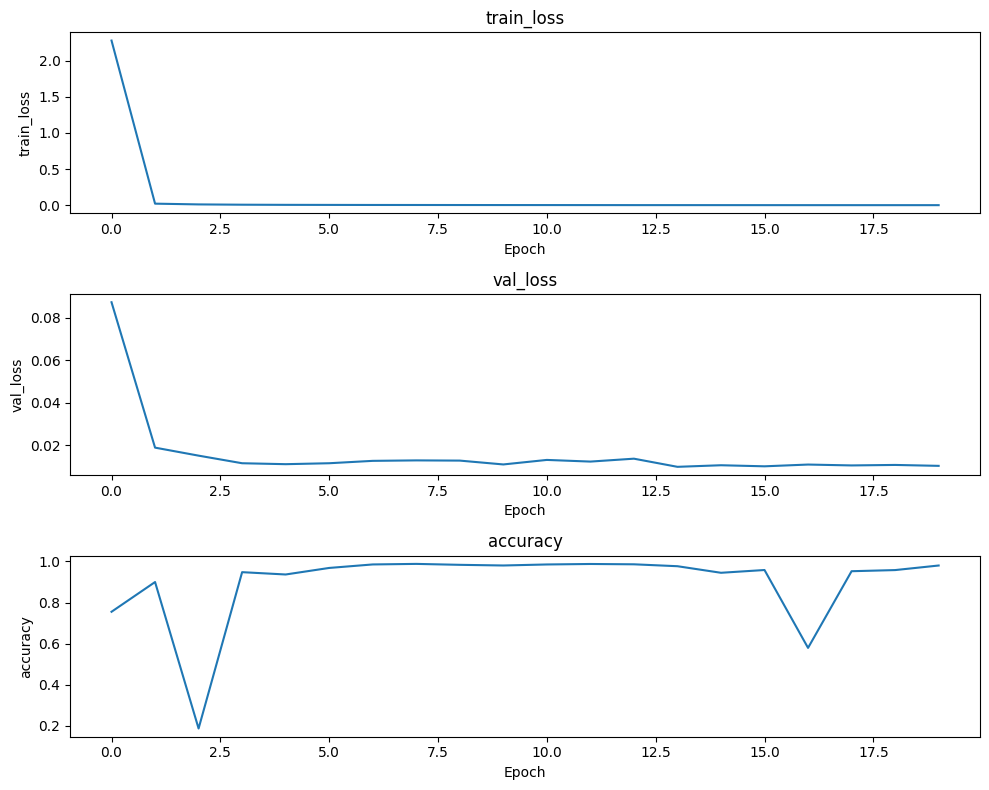

In [51]:
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics.keys()):
    axs[i].plot(metrics[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()